In [1]:
import warnings
warnings.filterwarnings("ignore")
import STCAT
import scanpy as sc
import scvi

In [2]:
adata = sc.read('/path/demo.h5ad')

In [3]:
print(adata)

AnnData object with n_obs × n_vars = 2977 × 31584
    obs: 'cell_type'
    layers: 'counts'


In [4]:
adata = STCAT.STCAT(adata)

🧮 T cell number : 2977
🧮 None T cell number : 0
💬 The input file seems not a raw count matrix.
✔ All genes and log1p normalized expression to 10000 counts per cell.
🔬 Input data has 2977 cells and 31584 genes
🔗 Matching reference genes in the model
🧬 1443 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 1
🗳️ Majority voting the predictions
✅ Majority voting done!
⚡ Process of CD4
⚡ Process of CD8
🔬 Input data has 969 cells and 31584 genes
🔗 Matching reference genes in the model
🔬 Input data has 1693 cells and 31584 genes
🔗 Matching reference genes in the model
🧬 2175 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 1
🗳️ 

In [5]:
print(adata)

AnnData object with n_obs × n_vars = 2960 × 31584
    obs: 'cell_type', 'Prediction', 'Cluster', 'Uncertainty score'
    layers: 'counts'


In [6]:
print(adata.obs.Prediction.value_counts())

Prediction
CD4 Tn       711
CD4 Tcm      484
CD8 Temra    404
CD8 Tn       394
CD4 Th17     345
MAIT         315
CD4 Treg     129
CD8 Tem      107
CD8 Tcm       43
CD4 Tc        23
CD8 Tc         5
Name: count, dtype: int64


In [7]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    layer="counts"
)

In [8]:
scvi.model.SCVI.setup_anndata(adata, layer="counts")
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)
model.train(max_epochs= 15)

Unable to initialize backend 'cuda': 
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO: GPU available: False, used: False
GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Epoch 15/15: 100%|██████████████████████████████████████████████████████████████████| 15/15 [00:42<00:00,  2.52s/it, v_num=1, train_loss_step=5.32e+3, train_loss_epoch=5.36e+3]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|██████████████████████████████████████████████████████████████████| 15/15 [00:42<00:00,  2.85s/it, v_num=1, train_loss_step=5.32e+3, train_loss_epoch=5.36e+3]


In [9]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="Prediction",
    unlabeled_category="Unknown"
)

In [10]:
scanvi_model.train(max_epochs=15)

INFO     Training for 15 epochs.                                                                                   


INFO: GPU available: False, used: False
GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Epoch 15/15: 100%|██████████████████████████████████████████████████████████████████| 15/15 [01:04<00:00,  3.66s/it, v_num=1, train_loss_step=5.25e+3, train_loss_epoch=5.29e+3]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|██████████████████████████████████████████████████████████████████| 15/15 [01:04<00:00,  4.31s/it, v_num=1, train_loss_step=5.25e+3, train_loss_epoch=5.29e+3]


In [11]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [12]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata, min_dist=0.3)

... storing 'Prediction' as categorical
... storing 'Cluster' as categorical


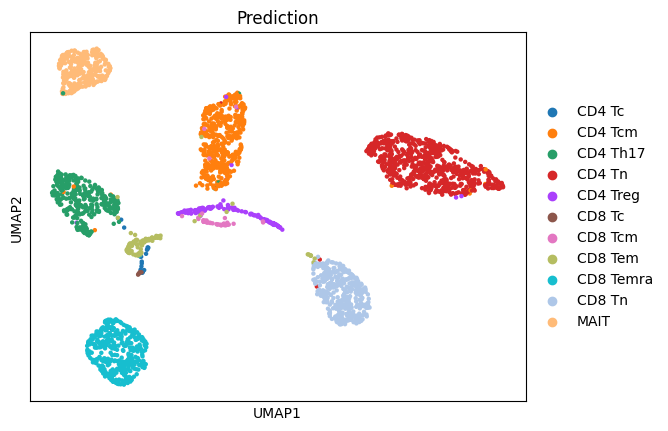

In [13]:
sc.pl.umap(adata,color=['Prediction'])